## Defining the problem

The number of people down with Mosquito-borne diseases is alarmingly on the rise. One such disease includes Malaria. Malaria is very common in tropical countries, serving as the leading cause of deaths in developing countries [1]. Diagnosis is a crucial stage in preventing the spread of any illnesses. Likewise, the identification of a parasitised cell is pivotal in the prevention of Malaria. 

Hence, through this project, I aim to use Machine Learning techniques and the universal workflow of Deep Learning to predict Malaria-infected cells. This will be done by analysing a dataset of parasitised and uninfected cells obtained from TensorFlow Datasets [2]. For this project, I have closely followed the workflow and techniques explained in the Deep Learning with Python book written by François Chollet [3].

## Assembling a dataset

This project handles a binary classification problem as it predicts a cell to be one of two classes; parasitised and uninfected. Since the type of problem is recognised to be a binary classification, I will build my network with a last-layer activation of 'sigmoid' and a loss function of 'binary_crossentropy'. 

The following code imports the tensorflow libraries and loads the dataset into this project.

In [20]:
# pip install tensorflow_datasets

In [21]:
import tensorflow as tf
import tensorflow_datasets as tfds

DATASET = 'malaria'
ds, ds_info = tfds.load(DATASET, split = 'all', 
                        with_info = True, 
                        shuffle_files = True)
# fig = tfds.show_examples(ds, ds_info)
print(ds)

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


## Choosing a measure of success

With the dataset and problem type established, it is important to understand what I am aiming to achieve through this project. As a model that predicts infected cells, it should be accurate and have minimal loss. Computing the area under the receiver operating characteristic curve (ROC AUC) will be a better metric since both classes of cells are equally likely to be predicted. 

In addition, determining the precision and recall can add to a better evaluation of my model's performance as 1 prediction should be as optimal as possible and my model should make as many correct predictions as possible. The measurments of these two factors will better aid in assessing my model.

Hence, as a metric for success, I will use the AUC, precision and recall and an accuracy score as indicators of my model's performance.

As a start to measure my model's competence, I will be building a baseline model which will be a basic model which only requires common sense. Building a model that performs better than the baseline gives it statistical power to continue training and improving on.

### Loss function
In order to capture how well my model has performed with each parameter differed, a distance score will be useful. Computing how far my model's predictions are from the true target can indicate my model's capabilities. Hence, to measure the distance score, I will be using binary crossentropy. The crossentropy function is a better measurement metric as compared to others such as the mean-squared-error as the output of my model's performance is a probability value due to the measures of success chosen. Hence, the loss function used in this project will be binary crossentropy.

### Optimiser

An optimiser which adapts and improves the model along the way is required. Based on the loss function chosen, the optimiser should be able to keep loss values at a minimum. Hence, the root mean squared propagation (RMSProp) optimiser will be a better choice. The loss alerted by the loss function will be attended to and reduced by the RMSProp optimiser as it normalises the gradient, minimising the instability of the model.

## Deciding on an evaluation protocol

With constant training of a model, the model is able to perform better each time with the training dataset. However, when applying the model on training data regularly, there is a high possibility that the model performs more and more poorly on unseen data, causing overfitting. Hence, I need to ensure my model does not only excel on training data by fluke, but also perform rightfully well on unseen data. One way to do that is using the hold-out validation technique.

With this technique, I will not only have a training and test data, but also a validation set which will be parted from the training set. When modifying my model, I will train on the first part of the training set and test on the validation set. As I constantly change the hyperparameters to modify my model, testing it on the validation set may leak information about the validation set to my model. This makes my model perform well on the validation set artificially. However, this is part of building my optimal model. Hence, to overrule this forced success, I will test my final model on the test data which will not be used anywhere before the final stage. The success measurements for my testing dataset should not be significantly worse than those for the validation set. As it is sufficient to evaluate a model using the hold-out validation technique, I will be using this.

## Preparing your data

As part of the preparation of my data, I will do the following:
- Resize the images.
- Reshape arrays into 1 dimension.
- Normalise pixels of images from [0, 255] to [0, 1].

Importing modules required to pre-process dataset.

In [22]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split

In [23]:
SEED = 204

tf.random.set_seed(SEED)
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

### Resize images
Before preparing my dataset, I will allocate the images and labels of the dataset to respective arrays. While doing that, I resized the images to size 28x28x3 using the resize() method.

In [24]:
RESIZE = (28, 28, 3)
GRAY_SCALE = True

images, labels = [], []
for entry in ds.take(len(ds)) :
    image, label = entry['image'], entry['label']
    
    image, label = image.numpy(), label.numpy()
    
    image = resize(image, RESIZE, anti_aliasing=True)
            
    if GRAY_SCALE :
        image = rgb2gray(image)
        
    images.append(image)
    labels.append(label)

2023-07-13 23:39:42.922104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [4]
	 [[{{node Placeholder/_1}}]]
2023-07-13 23:39:42.922605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]


### Reshape arrays
Thereafter, the images and labels arrays are converted to numpy arrays using the np.array() method. These images and labels numpy arrays are assigned as X and y variables.

The images (X) array is flattened from a 2 dimensional (28x28) array to 1 dimensional, while keeping all 27558 images, using the reshape() method.

In [25]:
# images array as a numpy array
X = np.array(images)

# binary output, 0 or 1
y = np.array(labels)

# flatten 2D image array to 1D array
X = X.reshape((X.shape[0], -1))
# y.shape
# len(X)
len(y) - len(X)

0

### Normalise pixels

Before normalising the pixels, I will split the dataset into training and testing sets. Firstly, I will allocate 20% of the dataset to the test set.

In [6]:
TEST_SIZE = 0.2

(X_train, X_test, 
 y_train, y_test) = train_test_split(X,
                                     y,
                                     test_size = TEST_SIZE,
                                     stratify = y,
                                     shuffle = True,
                                     random_state = SEED)

Now, I will scale the images to be in the [0, 1] interval from the [0, 255] interval. While doing so, I am also transforming the data into a float32 array which has the shape (27558, 28 * 28) as reshaped above.

In [7]:
# normalise pixels from [0, 255] to [0, 1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

With the normalised pixels, I will now create the validation set by drawing out a set of samples (same shape as the test set) from the training set.

In [8]:
VAL_SIZE = X_test.shape[0]

(X_train, X_val, 
y_train, y_val) = train_test_split(X_train,
                                   y_train,
                                   test_size = VAL_SIZE, 
                                   stratify = y_train,
                                   random_state = SEED,
                                   shuffle = True)

Summary of all training, testing and validation sets' shapes from the prepared data.

In [9]:
print('x_train:', X_train.shape)
print('y_train:', y_train.shape)

print('x_test:', X_test.shape)
print('y_test:', y_test.shape)

print('x_val:', X_val.shape)
print('y_val:', y_val.shape)

x_train: (16534, 784)
y_train: (16534,)
x_test: (5512, 784)
y_test: (5512,)
x_val: (5512, 784)
y_val: (5512,)


## Developing a model that does better than a baseline

Importing modules necessary to develop my model.

In [10]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

import itertools
import matplotlib.pyplot as plt

### Baseline

To begin developing my model, I will build a simple one which performs better than a straightforward baseline model. This baseline model will serve as a checkpoint to evaluate the performance of my model.

The baseline model I will use as reference will be a simple probability calculation, computing the chances of predicting the class of a random cell image. 

In [11]:
baseline = (len(y)-np.sum(y)) / len(y)

baseline

0.5

There is a 50% likelihood that the prediction of cell image's class is correct. The model I build hereafter will have to perform better than this with a higher value of accuracy.

### Declaring functions

Firstly, I will create a function to build the network, train the model, and plot the loss and AUC values respectively. These functions can then be applied when training my model depending on the parameters and complexities required.

In [12]:
# function to build, define and compile model
def build_network(hidden_layers = 0,
                  hidden_units = np.nan,
                  activation = None,
                  dropout = np.nan,
                  input_dimension = 2,
                  output_dimension = 1,
                  optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'],
                  name = None):

    model = Sequential()
    for layer in range(hidden_layers):
        model.add(Dense(hidden_units, 
                        activation, 
                        input_shape = 'default' if layer > 1 else (input_dimension,)))
        if ~np.isnan(dropout):
            model.add(Dropout(dropout))
    
    model.add(Dense(output_dimension, 
                    activation = 'sigmoid' if output_dimension == 1 else 'softmax',
                    input_shape = 'default' if hidden_layers > 0 else (input_dimension,)))
    
    if name is not None:
        model._name = name
    
    model.compile(optimizer, loss, metrics)
    
    return model

In [13]:
# function to train model
def train_model(model, 
                X, 
                y,
                class_weights,
                batch_size = 32,
                epochs = 100, 
                val_data = None, 
                callbacks = [], 
                seed = 0) :
    
    # if validation set has not been created
    if val_data is None :
        X_train, X_val, y_train, y_val = train_test_split(X, 
                                                          y, 
                                                          test_size = 0.2, 
                                                          random_state = seed, 
                                                          shuffle = True, 
                                                          stratify = y)
    else :
        X_train, y_train, X_val, y_val = X, y, val_data[0], val_data[1]

    history = model.fit(tf.expand_dims(X_train, axis=-1), 
                        y_train,
                        class_weight = class_weights,
                        batch_size = batch_size, 
                        epochs = epochs, 
                        validation_data = (X_val, y_val),
                        callbacks = callbacks,
                        verbose = 0)

    return {'model': model, 
            'val_score': model.evaluate(X_val, y_val, verbose=0)[1:], 
            'history': history }

In [14]:
# function to plot training and validation losses and AUCs
def plot_history(history, monitors = ['loss', 'AUC']):
    fig, axs = plt.subplots(1, 2, sharex = 'all', figsize = (15, 5))
    
    for ax, monitor in zip(axs.flat, monitors):
        loss, val_loss = history.history[monitor], history.history['val_' + monitor]
        
        if monitor == 'loss':
            monitor = monitor.capitalize()
        
        epochs = range(1, len(loss) + 1)
        
        ax.plot(epochs, loss, 'b.', label = monitor)
        ax.plot(epochs, val_loss, 'r', label = 'Validation ' + monitor)
        ax.set_xlim([0, len(loss)])
        ax.title.set_text('Training and validation ' + monitor)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(monitor)
        ax.legend()
        ax.grid()
    
    _ = plt.show()

### Underfit model

As mentioned above, I will first build a simple model that performs better than the baseline model. This model will underfit as it might perform poorly on training dataset itself due to the lack of complexity and training instances.

In [15]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

lr = 0.001

sim_model = build_network(hidden_layers = 0, 
                          hidden_units = 64,
                          activation = 'relu',
                          dropout = np.nan,
                          input_dimension = INPUT_DIMENSION,
                          output_dimension = OUTPUT_DIMENSION,
                          optimizer = RMSprop(learning_rate = lr),
                          loss = LOSS_FUNC,
                          metrics = METRICS,
                          name = "simple_model")

sim_model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 785       
                                                                 
Total params: 785
Trainable params: 785
Non-trainable params: 0
_________________________________________________________________


In [16]:
BATCH_SIZE = 128
EPOCHS = 500

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor = MONITOR, 
                           restore_best_weights = True, 
                           patience = PATIENCE, 
                           verbose = 0)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))

train_sim_model = train_model(sim_model, 
                              X_train,
                              y_train,
                              class_weights = CLASS_WEIGHTS,
                              epochs = EPOCHS, 
                              batch_size = BATCH_SIZE,
                              val_data = (X_val, y_val), 
                              callbacks = [EARLY_STOP],
                              seed = SEED)

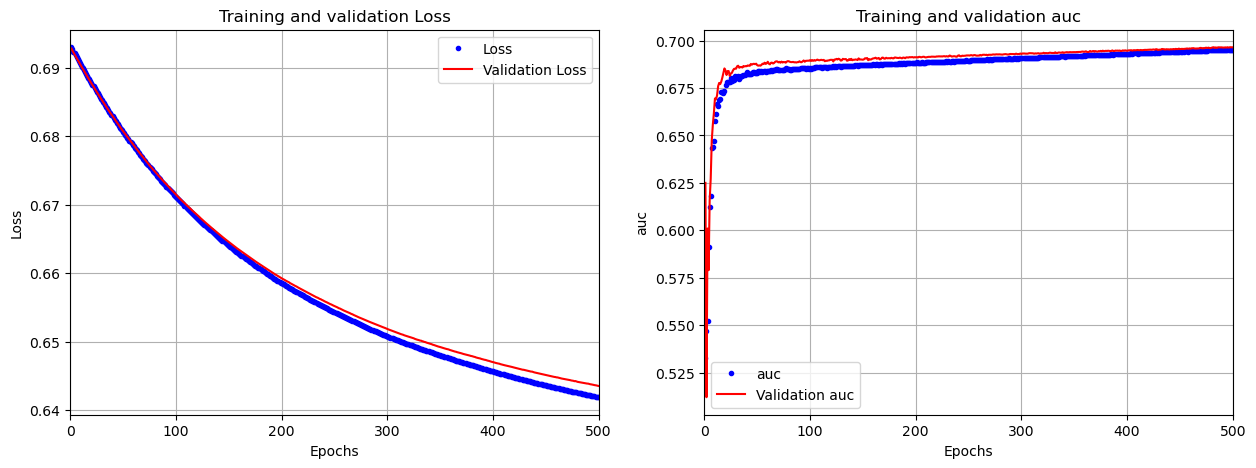

In [17]:
plot_history(train_sim_model['history'], monitors = ['loss', 'auc'])

In [18]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(train_sim_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(train_sim_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(train_sim_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(train_sim_model['val_score'][3]))


Accuracy (Validation): 0.64 (baseline=0.50)
Precision (Validation): 0.63
Recall (Validation): 0.68
AUC (Validation): 0.70


From measurements above, it is evident that my model's accuracy score of 64% is higher than that of the baseline model's which is 50%. This is sufficient to give my model statistical power. Hence, I will now build on this model with more complexity such as having a hidden layer.

## Scaling up: developing a model that overfits

After building a simple model that beats the baseline model's performance, I will modify the model by adding a hidden layer with hidden units into the neural network. This model might overfit as we are training it again after modifying it from the simple model above.

In [19]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

lr = 0.001

BATCH_SIZE = 128
EPOCHS = 500

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor = MONITOR, 
                           restore_best_weights = True, 
                           patience = PATIENCE, 
                           verbose = 0)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))


In [20]:
multi_model = build_network(hidden_layers = 1,
                            hidden_units = 64,
                            activation = 'relu',
                            dropout = np.nan,
                            input_dimension = INPUT_DIMENSION,
                            output_dimension = OUTPUT_DIMENSION,
                            optimizer = RMSprop(learning_rate = lr),
                            loss = LOSS_FUNC,
                            metrics = METRICS,
                            name = "multi_model")
multi_model.summary()

Model: "multi_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                50240     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________


In [21]:
train_multi_model = train_model(multi_model, 
                              X_train, 
                              y_train,
                              class_weights = CLASS_WEIGHTS,
                              epochs = EPOCHS,
                              batch_size = BATCH_SIZE, 
                              val_data = (X_val, y_val), 
                              callbacks = [EARLY_STOP], 
                              seed = SEED)

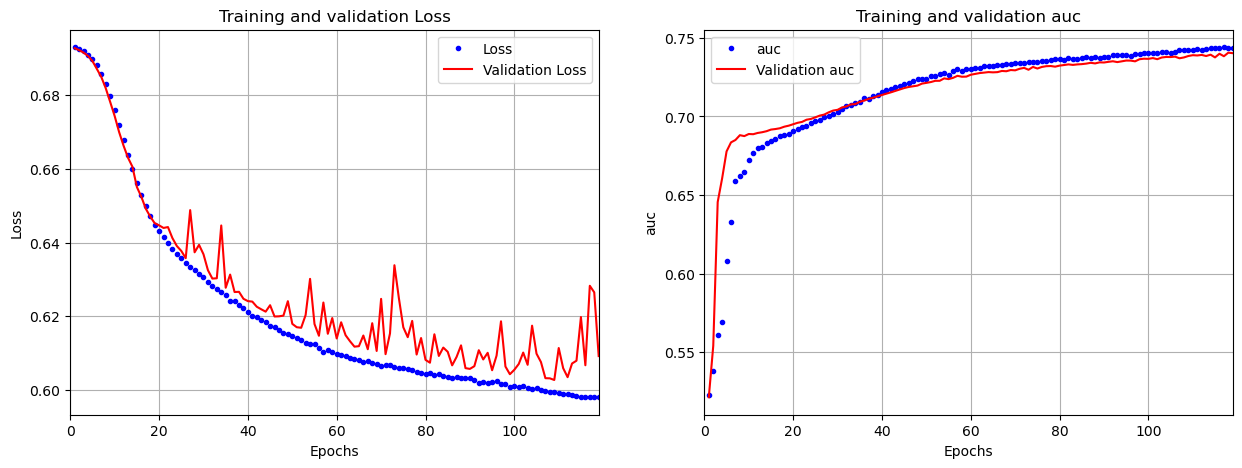

In [22]:
plot_history(train_multi_model['history'], monitors=['loss', 'auc'])

In [23]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(train_multi_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(train_multi_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(train_multi_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(train_multi_model['val_score'][3]))

Accuracy (Validation): 0.68 (baseline=0.50)
Precision (Validation): 0.68
Recall (Validation): 0.66
AUC (Validation): 0.74


As seen above, the measurements are higher as compared to those from the simple model. Although the model has performed better in terms of accurately predicting parasitized cells, the plots above show that an overfit has occured. Both the validation loss and validation AUC (red lines) are plotted further from the training loss and AUC (blue lines). The measurements of success on the validation set started to get poorer compared to the training set after about 25 epochs. This means, my model overoptimised on the training set that it was unable to generalise to a dataset outside the training set (such as the validation set). It can be infered that the optimal number of epochs to train my model with is 25.

Hence, hereafter, I will use 25 epochs to prevent overfitting when regularising my model.

### Replotting overfit loss and AUC graph with epochs = 25

For the subsequent judgement of the mitigation of overfitting, I will compare the loss and AUC plots against this plot.

In [24]:
# EPOCHS = 25
opt_EPOCHS = 25
train_multi_model = train_model(multi_model, 
                              X_train, 
                              y_train,
                              class_weights = CLASS_WEIGHTS,
                              epochs = opt_EPOCHS,
                              batch_size = BATCH_SIZE, 
                              val_data = (X_val, y_val), 
                              callbacks = [EARLY_STOP], 
                              seed = SEED)

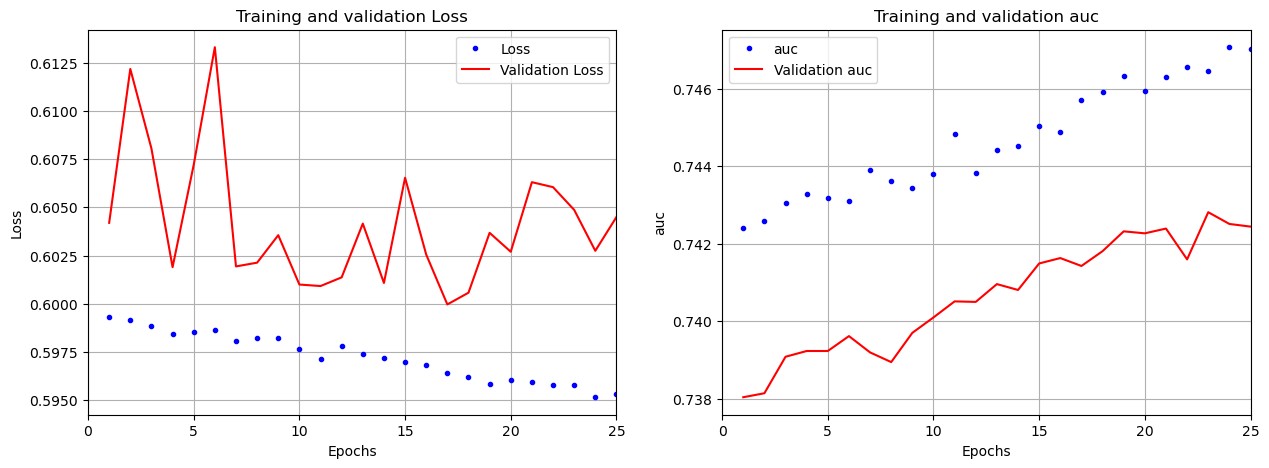

In [25]:
plot_history(train_multi_model['history'], monitors=['loss', 'auc'])

## Regularising model and tuning hyperparameters

### Add dropouts

To regularise my model, I will apply a dropout value to the layers in my neural network. This will mitigate the chances of overfitting as it sets a portion of the inputs to zero, introducing noise. This allows my network to perform better when there is lesser noise in the testing set. I will set the portion of inputs to be zeroed out to be 0.1. In addition, as mentioned before, I will be working with 25 epochs to add on to the mitigation of overfitting.

In [26]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

lr = 0.001

BATCH_SIZE = 128
opt_EPOCHS = 25

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor = MONITOR, 
                           restore_best_weights = True, 
                           patience = PATIENCE, 
                           verbose = 0)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))


In [27]:
dpout_model = build_network(hidden_layers = 1, 
                            hidden_units = 64,
                            activation = 'relu',
                            dropout = 0.1,
                            input_dimension = INPUT_DIMENSION,
                            output_dimension = OUTPUT_DIMENSION,
                            optimizer = RMSprop(learning_rate = lr),
                            loss = LOSS_FUNC,
                            metrics = METRICS,
                            name = "dpout_model")
dpout_model.summary()

Model: "dpout_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________


In [28]:
train_dpout_model = train_model(dpout_model,
                                 X_train, 
                                 y_train,
                                 class_weights = CLASS_WEIGHTS,
                                 epochs = opt_EPOCHS,
                                 batch_size = BATCH_SIZE, 
                                 val_data = (X_val, y_val), 
                                 callbacks = [EARLY_STOP], 
                                 seed = SEED)

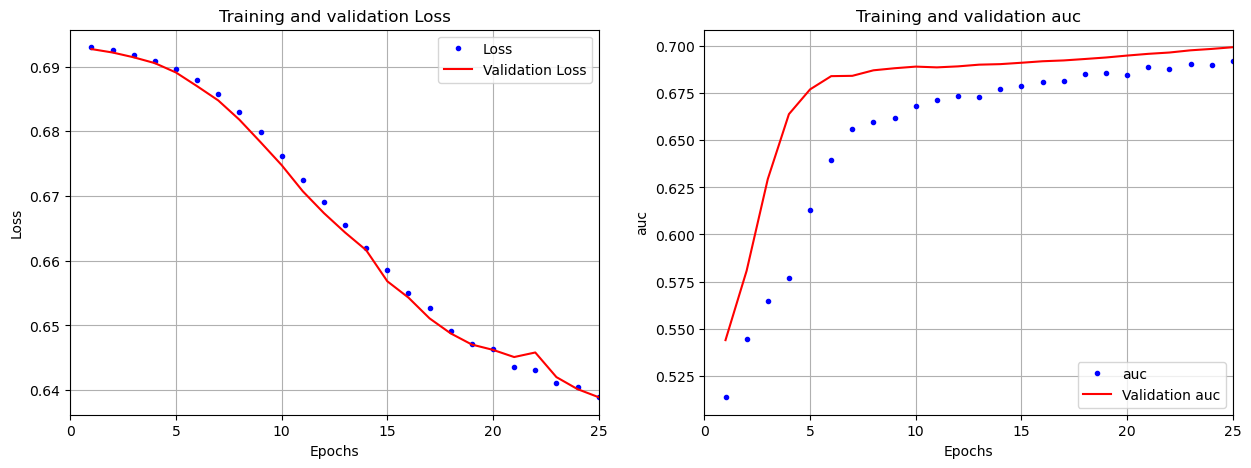

In [29]:
plot_history(train_dpout_model['history'], monitors=['loss', 'auc'])

In [30]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(train_dpout_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(train_dpout_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(train_dpout_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(train_dpout_model['val_score'][3]))


Accuracy (Validation): 0.64 (baseline=0.50)
Precision (Validation): 0.62
Recall (Validation): 0.72
AUC (Validation): 0.70


It is notable that the validation loss and AUC lines have grown much closer to the training loss and AUC lines as compared to the plots before. This indicates that overfitting has been mitigated to a great extent.

### Add L2 regularisation

Another way of preventing overfitting is the L1/L2 regularisation. I will be applying a L2 regularisation as it evenly factorises the weights to be a small value, allowing my model to be less complicated.

In [31]:
OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

lr = 0.001

BATCH_SIZE = 128
opt_EPOCHS = 25

In [32]:
reg_model = Sequential()

reg_model.add(Dense(64, 
                    kernel_regularizer = regularizers.l2(0.001), 
                    activation = 'relu'))

reg_model.add(Dense(OUTPUT_DIMENSION, activation = 'sigmoid'))

reg_model.compile(optimizer = RMSprop(learning_rate = lr), 
                  loss = LOSS_FUNC, 
                  metrics = METRICS)

history = reg_model.fit(X_train,
                      y_train,
                      epochs = opt_EPOCHS, 
                      batch_size = BATCH_SIZE,
                      validation_data = (X_val, y_val),
                      verbose = 0)

reg_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                50240     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________


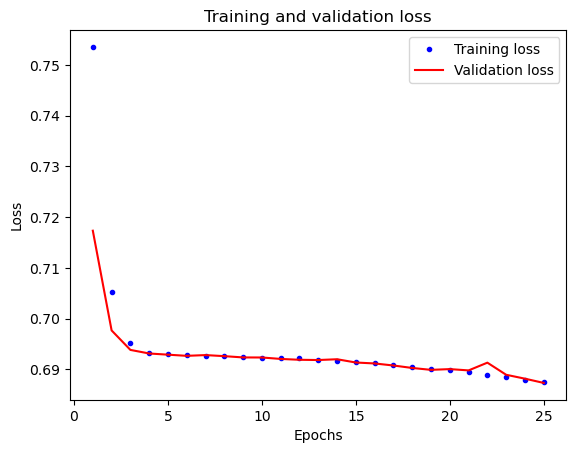

In [33]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b.', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

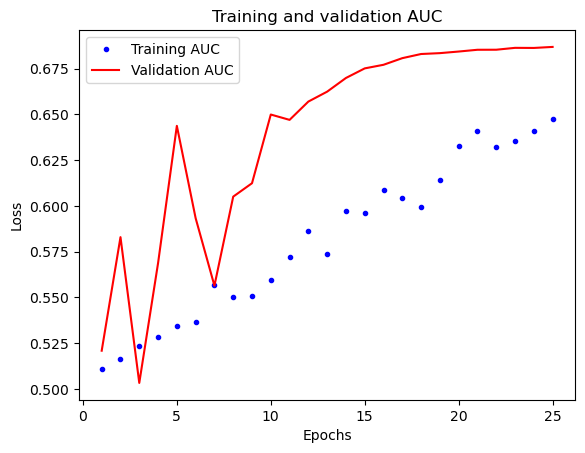

In [34]:
history_dict = history.history
auc = history_dict['auc']
val_auc = history_dict['val_auc']

epochs = range(1, len(auc) + 1)

plt.plot(epochs, auc, 'b.', label='Training AUC')
plt.plot(epochs, val_auc, 'r-', label='Validation AUC')

plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [35]:
results = reg_model.evaluate(X_test, y_test)
results

173/173 [==============================] - 0s 1ms/step - loss: 0.6873 - accuracy: 0.5909 - precision: 0.5614 - recall: 0.8316 - auc: 0.6867


[0.6873133182525635,
 0.5908926129341125,
 0.5613519549369812,
 0.8316400647163391,
 0.6866636276245117]

It can be seen that the L2 regularisation performed better with the training and validation loss. However, training and validation AUCs are greatly affected and worsened compared to the addition of dropout values. Hence, this technique of regularisation will be undesirable.

### Trying different hyperparameters

#### Changing number of hidden units per layer
So far, I have used 64 units per layer in every modification of my model. Now, as part of expanding my network, I will train my model using a different number of units per layer while keeping other hyperparameters the same.

In [36]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

lr = 0.001

BATCH_SIZE = 128
opt_EPOCHS = 25

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor = MONITOR, 
                           restore_best_weights = True, 
                           patience = PATIENCE, 
                           verbose = 0)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))


In [37]:
# 16 hidden_units
units_model = build_network(hidden_layers = 1,
                            hidden_units = 16,
                            activation = 'relu',
                            dropout = np.nan,
                            input_dimension = INPUT_DIMENSION,
                            output_dimension = OUTPUT_DIMENSION,
                            optimizer = RMSprop(learning_rate = lr),
                            loss = LOSS_FUNC,
                            metrics = METRICS,
                            name = "units_model")

train_units_model = train_model(units_model,
                                 X_train, 
                                 y_train,
                                 class_weights = CLASS_WEIGHTS,
                                 epochs = opt_EPOCHS,
                                 batch_size = BATCH_SIZE, 
                                 val_data = (X_val, y_val), 
                                 callbacks = [EARLY_STOP], 
                                 seed = SEED)

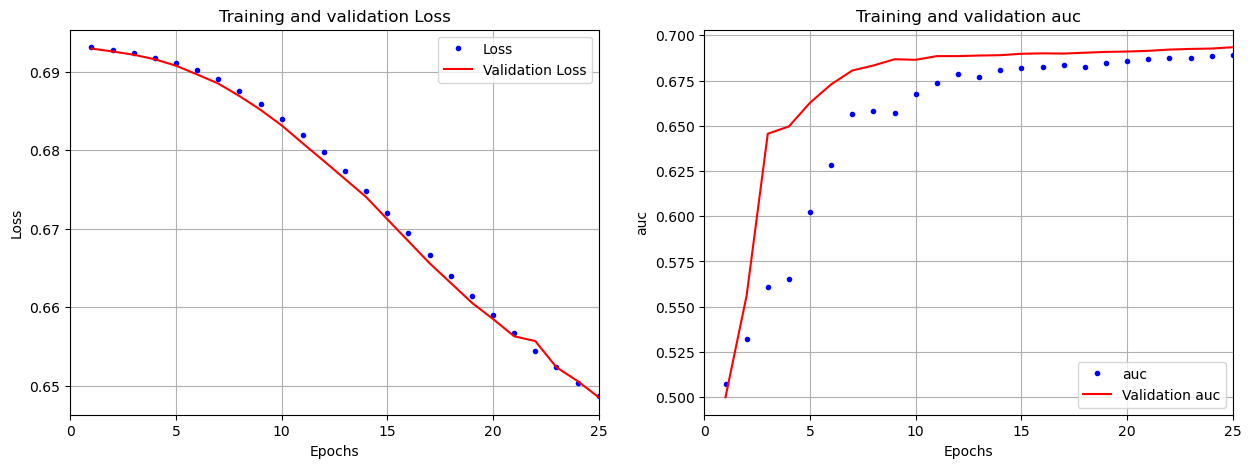

In [38]:
plot_history(train_units_model['history'], monitors=['loss', 'auc'])

In [39]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(train_units_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(train_units_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(train_units_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(train_units_model['val_score'][3]))


Accuracy (Validation): 0.63 (baseline=0.50)
Precision (Validation): 0.62
Recall (Validation): 0.70
AUC (Validation): 0.69


Changing the number of units in each layer from 64 to 16 has significantly prevented overfitted. The validation and training losses are closer to each other. Although the training and validation AUCs are quite differed for the first 5 epochs, there are relatively closer to each other as compared to when number of units per layer was 64. Hence, 16 units per layer is more desirable.

#### Changing learning rate

Similarly, I have used a learning rate of 0.001 in each of the models built. Now I will train my model using a different learning rate of 0.005 while keeping other hyperparameters the same.

In [40]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]

BATCH_SIZE = 128
opt_EPOCHS = 25

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor = MONITOR, 
                           restore_best_weights = True, 
                           patience = PATIENCE, 
                           verbose = 0)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))


In [41]:
# 0.005 learning rate
lr = 0.005

lr_model = build_network(hidden_layers = 1, 
                         hidden_units = 64,
                         activation = 'relu',
                         dropout = np.nan,
                         input_dimension = INPUT_DIMENSION,
                         output_dimension = OUTPUT_DIMENSION,
                         optimizer = RMSprop(learning_rate = lr),
                         loss = LOSS_FUNC,
                         metrics = METRICS,
                         name = "lr_model")

train_lr_model = train_model(lr_model,
                             X_train, 
                             y_train,
                             class_weights = CLASS_WEIGHTS,
                             epochs = opt_EPOCHS,
                             batch_size = BATCH_SIZE, 
                             val_data = (X_val, y_val), 
                             callbacks = [EARLY_STOP], 
                             seed = SEED)

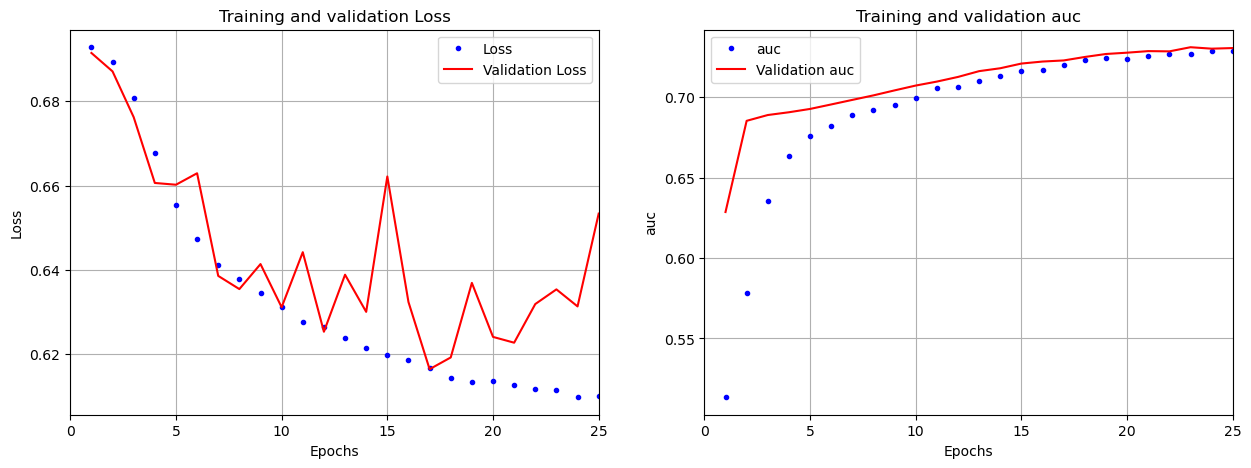

In [42]:
plot_history(train_lr_model['history'], monitors=['loss', 'auc'])

In [43]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(train_lr_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(train_lr_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(train_lr_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(train_lr_model['val_score'][3]))


Accuracy (Validation): 0.62 (baseline=0.50)
Precision (Validation): 0.58
Recall (Validation): 0.90
AUC (Validation): 0.73


It can be seen from the plots that the validation AUC is close to the training AUC compared to the model with learning rate of 0.001. However, the validation loss largely deviates from the training loss as compared to a learning rate of 0.001. Overfitting has not been prevented acceptably. Hence, I will be keeping the learning rate of my model to 0.001 instead of 0.005.

### Final Model

Based on the regularisations of my model done so far, it can be concluded that adding a dropout rate performed better than an L2 regularisation. It also performed better than the model before regularisation. Hence, I will add a dropout rate for my finalised model.

Likewise, changing the number of units per layer performed better than changing the learning rate. It also performed better than the 64 units per layer used originally. 

Hence, the number of units per layer will be changed to 16 and a dropout value of 0.1 will be applied to my final model.

#### Combining modifications that produced optimal configuration

As mentioned above, the hyperparameters that produced improved results are the change in units per layer and an addition of a dropout factor. The following will keep all other hyperparameters the same as the model before regularisation.

In [44]:
INPUT_DIMENSION = X_train.shape[1]
OUTPUT_DIMENSION = 1

OPTIMIZER = 'rmsprop'
LOSS_FUNC = 'binary_crossentropy'
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name = 'precision'), 
           tf.keras.metrics.Recall(name = 'recall'),
           tf.keras.metrics.AUC(name = 'auc')]
lr = 0.001

BATCH_SIZE = 128
opt_EPOCHS = 25

MONITOR = 'val_loss'
PATIENCE = 10

EARLY_STOP = EarlyStopping(monitor = MONITOR, 
                           restore_best_weights = True, 
                           patience = PATIENCE, 
                           verbose = 0)

weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
CLASS_WEIGHTS = dict(enumerate(weights))

The number of units per layer will now be 16, and a dropout factor of 0.1 is added in the parameters of the build_network function as seen below.

In [45]:
final_model = build_network(hidden_layers = 1, 
                            hidden_units = 16,
                            activation = 'relu',
                            dropout = 0.1,
                            input_dimension = INPUT_DIMENSION,
                            output_dimension = OUTPUT_DIMENSION,
                            optimizer = RMSprop(learning_rate = lr),
                            loss = LOSS_FUNC,
                            metrics = METRICS,
                            name = "final_model")

In [46]:
train_final_model = train_model(final_model,
                                 X_train, 
                                 y_train,
                                 class_weights = CLASS_WEIGHTS,
                                 epochs = 25,
                                 batch_size = BATCH_SIZE, 
                                 val_data = (X_val, y_val), 
                                 callbacks = [EARLY_STOP], 
                                 seed = SEED)

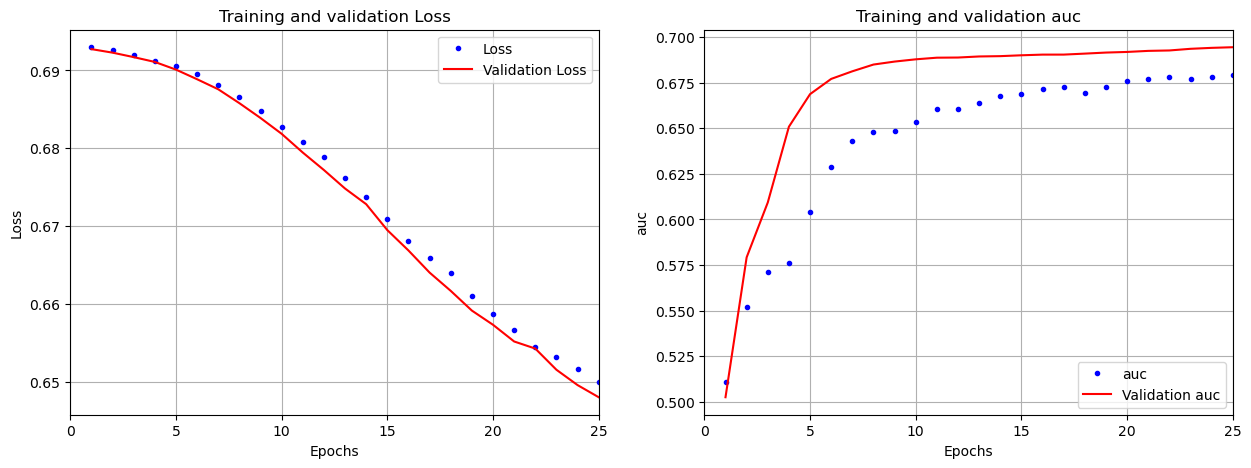

In [47]:
plot_history(train_final_model['history'], monitors=['loss', 'auc'])

In [48]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(train_final_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(train_final_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(train_final_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(train_final_model['val_score'][3]))


Accuracy (Validation): 0.63 (baseline=0.50)
Precision (Validation): 0.62
Recall (Validation): 0.71
AUC (Validation): 0.69


The plots show that the training and validation losses are very closely plotted, indicating a good model fit. The training and validation AUCs are notably nearer to each other compared to the other modified models trained so far. Although this does not indicate a good fit, there was a prevention of overfitting. In addition, the measurements of success are also relatively acceptable.

### Train on all available data

With the final model configured, I will now concatenate my training and validation sets, training the model on this new combined training set, and test on the test set.

In [49]:
full_data = (np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

train_alld_model = train_model(final_model,
                                 X_train, 
                                 y_train,
                                 class_weights = CLASS_WEIGHTS,
                                 epochs = opt_EPOCHS,
                                 batch_size = BATCH_SIZE, 
                                 val_data = full_data, 
                                 callbacks = [EARLY_STOP], 
                                 seed = SEED)

In [50]:
print('Accuracy (Validation): {:.2f} (baseline={:.2f})'.format(train_alld_model['val_score'][0], baseline))
print('Precision (Validation): {:.2f}'.format(train_alld_model['val_score'][1]))
print('Recall (Validation): {:.2f}'.format(train_alld_model['val_score'][2]))
print('AUC (Validation): {:.2f}'.format(train_alld_model['val_score'][3]))


Accuracy (Validation): 0.65 (baseline=0.50)
Precision (Validation): 0.64
Recall (Validation): 0.69
AUC (Validation): 0.71


### Testing final model on unseen test set.

In [51]:
preds = train_alld_model['model'].predict(X_test)

print('Accuracy (Test): {:.2f} (baseline={:.2f})'.format(accuracy_score(y_test, (preds > 0.5).astype('int32')), baseline))
print('Precision (Test): {:.2f}'.format(precision_score(y_test, (preds > 0.5).astype('int32'))))
print('Recall (Test): {:.2f}'.format(recall_score(y_test, (preds > 0.5).astype('int32'))))
print('AUC (Test): {:.2f}'.format(roc_auc_score(y_test, preds)))


173/173 [==============================] - 0s 868us/step
Accuracy (Test): 0.66 (baseline=0.50)
Precision (Test): 0.65
Recall (Test): 0.71
AUC (Test): 0.72


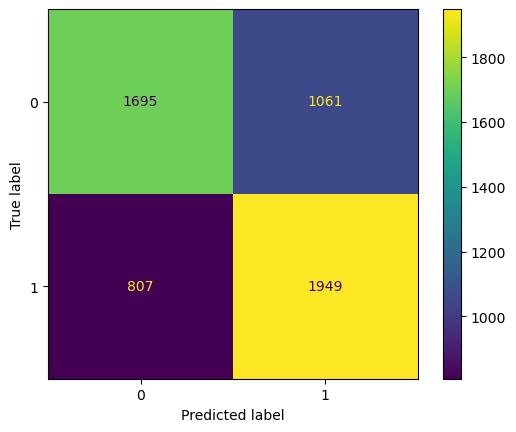

In [52]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, (preds > 0.5).astype('int32')) )
_ = disp.plot()

## Analysis

As seen in the success metrics and the confusion matrix above, it can be said that my model was able to perform at an accuracy score of 66%. Although this is a low accuracy rate for a machine learning model, the desirable modifications made to my model has yeilded consistent accuracy rates.

Using the hold-out validation technique, my model has a accuracy rate of 65% on the validation set and 66% the test set. The overall performance of my model on the unseen test data is very similar yet better than that on the validation data. This indicates that my model is able to perform relatively well on completely unseen data and will yeild good measurements of success.

In the future, as part of developing my model, I will build my network using other evaluation protocols such as the iterated K-fold validation, using a larger dataset.

## References

[1] CDC Centers for Disease Control and Prevention (2021). Malaria’s Impact Worldwide. Available from https://www.cdc.gov/malaria/malaria_worldwide/impact.html#:~:text=Malaria%20is%20one%20of%20the,are%20the%20groups%20most%20affected.

[2] TensorFlow (2022). malaria. Available from https://www.tensorflow.org/datasets/catalog/malaria

In [ ]:
@article{rajaraman2018pre,
  title={Pre-trained convolutional neural networks as feature extractors toward
  improved malaria parasite detection in thin blood smear images},
  author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh
  and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger,
  Stefan and Thoma, George R},
  journal={PeerJ},
  volume={6},
  pages={e4568},
  year={2018},
  publisher={PeerJ Inc.}
}

[3] Chollet, F. (2017). Deep learning with python. Manning Publications.